### ToDo
* changing resource state 
* changing setup for each op 
    * may not required as you have the current operation with the req setup
    * and we do not consider setup times.
* monitoring the basics
* Material (Charge, Qualität, usw)
* Vorgänger (und Nachfolger) auf der Maschine speichern (vollständige Historie) --> Erweiterung: Stack/Queue mit "x Elementen" oder einen "x Zeitraum"
* alternative Maschine aus Maschinengruppe nutzen (optional?)
* Giffler - offene Operationen für die Inferencing
* run-event selbst bauen warten bis zum Endschritt 

In [21]:
from plan.GifflerThompson import GifflerThompson
from plan.HodgsonMoore import HodgsonMooreAlgorithm
from factory.Operation import Operation
from simulation.Simulator import Simulator
from causal.causal_model import CausalModel
from generators.jobs_data_generator import JobsDataGenerator
import random

import pandas as pd
# Beispielhafte Datenstruktur
template_jobs_data = [
    ['p1', 1, 'a1', 17, 2],
    ['p1', 2, 'a2', 30, 4],
    ['p1', 3, 'a3', 14, 4],
    ['p1', 4, 'a4', 15, 5],
    ['p1', 5, 'a5', 25, -1],
    ['p2', 1, 'a1', 13, 3],
    ['p2', 2, 'a3', 15, 3],
    ['p2', 3, 'a2', 10, 4],
    ['p2', 4, 'a6', 20, -1],
]

generator = JobsDataGenerator(template_jobs_data)
num_instances = 150  # Number of new instances to generate
relation = {'p1': 0.5, 'p2': 0.5}  # Relation of each product type

jobs_data = generator.generate_jobs_data(num_instances, relation)


# Maschinenpools definieren
# id, number, tools 
machine_pools_data = [
    ['a1', 2, [1,2,3]],
    ['a2', 1, [1,2,3]],
    ['a3', 2, [1,2,3]],
    ['a4', 1, [1,2,3]],
    ['a5', 1, [1,2,3]],
    ['a6', 1, [1,2,3]],
]

# Konvertiere die jobs_data in Operation-Objekte
operations = [Operation(*data) for data in jobs_data]

# Define a priority rule
def calculate_dynamic_priority(operation) -> int:
    # Priorität basierend auf der geplanten Startzeit der Vorgängeraufgaben
    if not operation.predecessor_operations:
        return operation.plan_start if operation.plan_start is not None else 0
    else:
        return max(pred.plan_start for pred in operation.predecessor_operations) + operation.duration


# causal model
observed_data = []
csv_file = 'data/observed_data.csv'
model = CausalModel(csv_file=csv_file)

# Causal model for simulation
# define an inference rule    
def simulation_inference(operation: Operation) -> int:
 
    # 1. Preperation step
    has_lots_operations = len(operation.predecessor_operations) > 1
    is_shorter_than_15 =  operation.plan_duration < 15
    filtered_pools = [pool for pool in sim.pools.values() if pool.group == operation.machine.group and pool.id != operation.machine.id]
    one_working = any(pool.current_operation is not None for pool in filtered_pools) 
    
    # 2. Infer step
    duration_factor = model.infer_duration(True, has_lots_operations, is_shorter_than_15, one_working)

    # 3. Calculation step
    new_duration = round(operation.duration * duration_factor,0)
    
    # Save for causal learning
    observed_data.append([has_lots_operations, is_shorter_than_15, one_working, duration_factor])
    
    print(f"Operation duration was: {operation.duration} and has been changed to {new_duration}")
    return new_duration

# Causal model for planning
# define an inference rule    
def plan_inference(operation: Operation) -> int:
    
    # 1. Preperation step
    has_lots_operations = len(operation.predecessor_operations) > 1
    is_shorter_than_15 =  operation.plan_duration < 15
    
    #TODO add the free resources from the gt.schedule
    # gt.schedule
    
    #filtered_pools = [pool for pool in sim.pools.values() if pool.group == operation.machine.group and pool.id != operation.machine.id]
    #one_working = any(pool.current_operation is not None for pool in filtered_pools) 
    one_working = random.choice([True, False])
    # 2. Infer step
    duration_factor = model.infer_duration(False, has_lots_operations, is_shorter_than_15, one_working)

    # 3. Calculation step
    new_duration = round(operation.duration * duration_factor,0)
    return new_duration

# Causal model for planning
# define an inference rule    
def plan_inference_non(operation: Operation) -> int:
    return operation.duration


hodgens = HodgsonMooreAlgorithm()
hodgens_schedule = hodgens.schedule_jobs(operations, machine_pools_data)


# Führe den Giffler Thompson Algorithmus aus
gt = GifflerThompson(calculate_dynamic_priority, plan_inference)
gt_causal_schedule = gt.giffen_thompson(operations, machine_pools_data)

# Führe den Giffler Thompson Algorithmus aus
non_causal = GifflerThompson(calculate_dynamic_priority, plan_inference_non)
gt_non_causal_schedule = non_causal.giffen_thompson(operations, machine_pools_data)


result_schedule = gt_non_causal_schedule
# Ausgabe des Ergebnisses
for entry in result_schedule:
    print(entry)

  0%|          | 4/1000000 [00:00<2:03:06, 135.38it/s]


Operation(job_id='p103', operation_id=1, plan_machine_id='a1_0', duration=13, successor=3, plan_start=0, plan_end=13)
Operation(job_id='p103', operation_id=2, plan_machine_id='a3_0', duration=15, successor=3, plan_start=0, plan_end=15)
Operation(job_id='p104', operation_id=2, plan_machine_id='a3_1', duration=15, successor=3, plan_start=0, plan_end=15)
Operation(job_id='p68', operation_id=1, plan_machine_id='a1_1', duration=13, successor=3, plan_start=0, plan_end=13)
Operation(job_id='p103', operation_id=3, plan_machine_id='a2_0', duration=10, successor=4, plan_start=25, plan_end=35)
Operation(job_id='p103', operation_id=3, plan_machine_id='a2_0', duration=10, successor=4, plan_start=25, plan_end=35)
Operation(job_id='p104', operation_id=1, plan_machine_id='a1_0', duration=13, successor=3, plan_start=13, plan_end=26)
Operation(job_id='p108', operation_id=1, plan_machine_id='a1_1', duration=13, successor=3, plan_start=13, plan_end=26)
Operation(job_id='p108', operation_id=2, plan_machine

In [2]:
from simulation.Simulator import Simulator
from simulation.Monitoring.BasicMonitor import monitorResource
from functools import partial

# array to store monitored data
data = []

# resource monitor [pre , post] execution
monitor = [None, partial(monitorResource, data)]

sim = Simulator(machine_pools_data
                , result_schedule
                , monitor
                , simulation_inference)

sim.env.run(300)

0
0
18.0
28.0
20.0
13.0
64.0
74.0
0
28.0
18.0
64.0
82.0
33.0
31.0
110.0
119.0
13.0
74.0
0
110.0
128.0
53.0
49.0
155.0
165.0
33.0
119.0
29.0
155.0
171.0
66.0
56.0
204.0
213.0
46.0
165.0
43.0
204.0
222.0
88.0
81.0
249.0
259.0
66.0
213.0
67.0
249.0
269.0
99.0
99.0
295.0
305.0
79.0
259.0
76.0
295.0
313.0
102.0
90.0
305.0
329.0
131.0
122.0
351.0
361.0
111.0
315.0
108.0
351.0
369.0
114.0
361.0
117.0
394.0
414.0
154.0
144.0
430.0
440.0
134.0
394.0
130.0
430.0
450.0
164.0
155.0
479.0
489.0
144.0
440.0
140.0
479.0
497.0
167.0
162.0
489.0
513.0
177.0
173.0
499.0
537.0
180.0
191.0
508.0
561.0
190.0
518.0
180.0
557.0
575.0
213.0
209.0
593.0
603.0
193.0
557.0
194.0
593.0
611.0
226.0
221.0
603.0
627.0
230.0
229.0
649.0
659.0
210.0
613.0
207.0
649.0
667.0
243.0
247.0
659.0
683.0
256.0
251.0
669.0
707.0
259.0
265.0
715.0
731.0
239.0
679.0
237.0
715.0
735.0
272.0
269.0
725.0
757.0
269.0
283.0
735.0
781.0
282.0
287.0
745.0
805.0
285.0
754.0
301.0
790.0
808.0
295.0
790.0
305.0
829.0
847.0
324.0
330.0
865

## Some statistics to compare the plan

In [23]:
import pandas as pd

def calculate_makespan(schedule, schedule_name):
    # Convert the list of operation objects to a DataFrame
    df_schedule = pd.DataFrame([op.__dict__ for op in schedule])

    # Calculate start and end times for each job
    grouped_schedule = df_schedule.groupby('job_id').agg({'plan_start': 'min', 'plan_end': 'max'})

    # Calculate the makespan for each job
    grouped_schedule['makespan'] = grouped_schedule['plan_end'] - grouped_schedule['plan_start']

    # Calculate the average makespan across all jobs
    average_makespan = grouped_schedule['makespan'].mean()

    # Output the results with the schedule name
    print(f"The average makespan across all products in the {schedule_name} schedule is: {average_makespan} time units.")

# Example usage with named schedules
calculate_makespan(gt_non_causal_schedule, 'Causal')
calculate_makespan(gt_causal_schedule, 'NonCausal')


KeyboardInterrupt: 

In [4]:
df_observed_data = pd.DataFrame(observed_data, columns=['has_lots_operations','is_shorter_than_15','one_working', 'duration'])
df_observed_data.to_csv("data/observed_data.csv")

In [5]:
for d in data:
    print(d)

('a1_0', None, 0, 1, 0)
('a3_0', None, 0, 1, 0)
('a1_1', None, 0, 1, 0)
('a3_1', None, 0, 1, 0)
('a1_0', Operation(job_id='p100', operation_id=1, plan_machine_id='a1_0', duration=13, successor=3, plan_start=0, plan_end=13.0), 12.0, 0, 0)
('a3_1', Operation(job_id='p101', operation_id=3, plan_machine_id='a3_1', duration=14, successor=4, plan_start=0, plan_end=13.0), 13.0, 0, 0)
('a3_1', None, 13.0, 1, 0)
('a1_0', None, 13.0, 1, 0)
('a3_0', Operation(job_id='p100', operation_id=2, plan_machine_id='a3_0', duration=15, successor=3, plan_start=0, plan_end=18.0), 16.0, 0, 0)
('a2_0', None, 18.0, 1, 0)
('a3_0', None, 18.0, 1, 0)
('a1_1', Operation(job_id='p10', operation_id=1, plan_machine_id='a1_1', duration=17, successor=2, plan_start=0, plan_end=20.0), 20.0, 0, 0)
('a1_1', None, 20.0, 1, 0)
('a2_0', Operation(job_id='p100', operation_id=3, plan_machine_id='a2_0', duration=10, successor=4, plan_start=18.0, plan_end=28.0), 27.0, 0, 0)
('a6_0', None, 28.0, 1, 0)
('a2_0', None, 28.0, 1, 0)
('a

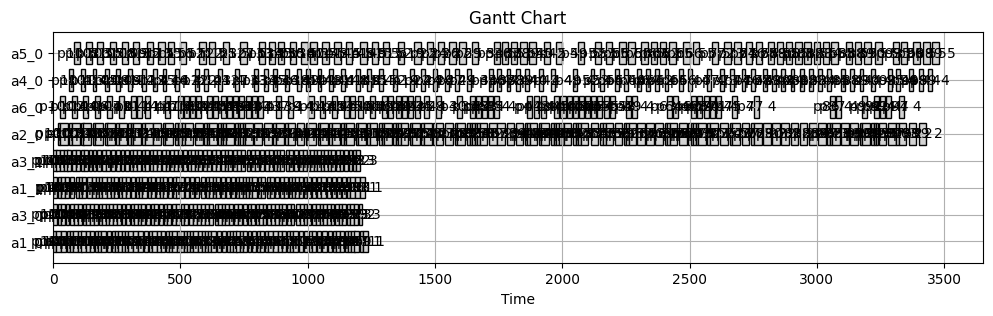

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import math

# Daten in ein DataFrame konvertieren
df = pd.DataFrame([p.to_dict() for p in result_schedule])

size_height = math.ceil(df["machine"].count().itemsize / 3)
# Gantt-Diagramm erstellen
fig, ax = plt.subplots(figsize=(12, size_height))

# Maschinen als y-Werte für die Balken
machines = df['machine'].unique()
machine_to_y = {machine: i for i, machine in enumerate(machines)}

# Iteriere über jede Zeile des DataFrames
for i, row in df.iterrows():
    start = row['start_time']
    duration = row['duration']
    job_id = row['job_id']
    task_id = row['operation_id']
    machine = row['machine']
    label = f'{job_id} {task_id}'

    # Stelle die Aufgabe als Balken im Diagramm dar
    ax.barh(y=machine_to_y[machine], left=start, width=duration, height=0.8, align='center', color='lightgrey', edgecolor='black')
    
    # Text in den Balken einfügen
    ax.text(x=start + duration / 2, y=machine_to_y[machine], s=label, va='center', ha='center', color='black')

# Diagramm formatieren
ax.set_xlabel('Time')
ax.set_yticks(list(machine_to_y.values()))
ax.set_yticklabels(list(machine_to_y.keys()))
ax.set_title('Gantt Chart')

# Grid anzeigen
ax.grid(True)

# Legende entfernen, da sie nicht mehr notwendig ist
# Handles und Labels der Legende deduplizieren
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())

# Diagramm anzeigen
plt.show()
